In [32]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
# ------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Описание выбранного набора данных и решаемая задача

Тема курсовой работы **"Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения"**

Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи курсовой работы необходимо определить решаему задачу в области машщинного обучения и данные её характеризующие, выбрать модель в равной степени хорошо подходящую для решения обеих задач.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "одобрить кредит" или "не одобрить кредит" по некторому набору признаков. Набор данных взять с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

Набор данных представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30**-59DaysPastDueNotWorse - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому  вдальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.

В данной работе для оптимизации выбрана модель дерева решений по ряду причин:
- Легкость настройки - ряд ключевых гипперпараметров модели представляют собой целочисленные значения, что значительно облегчит применение байесовской оптимизации;
- Хороший baseline - построенная и оптимизированная модель послужит хорошей основой для дальнейшей работы и улучшения результатов;

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [33]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


(None, None, None)

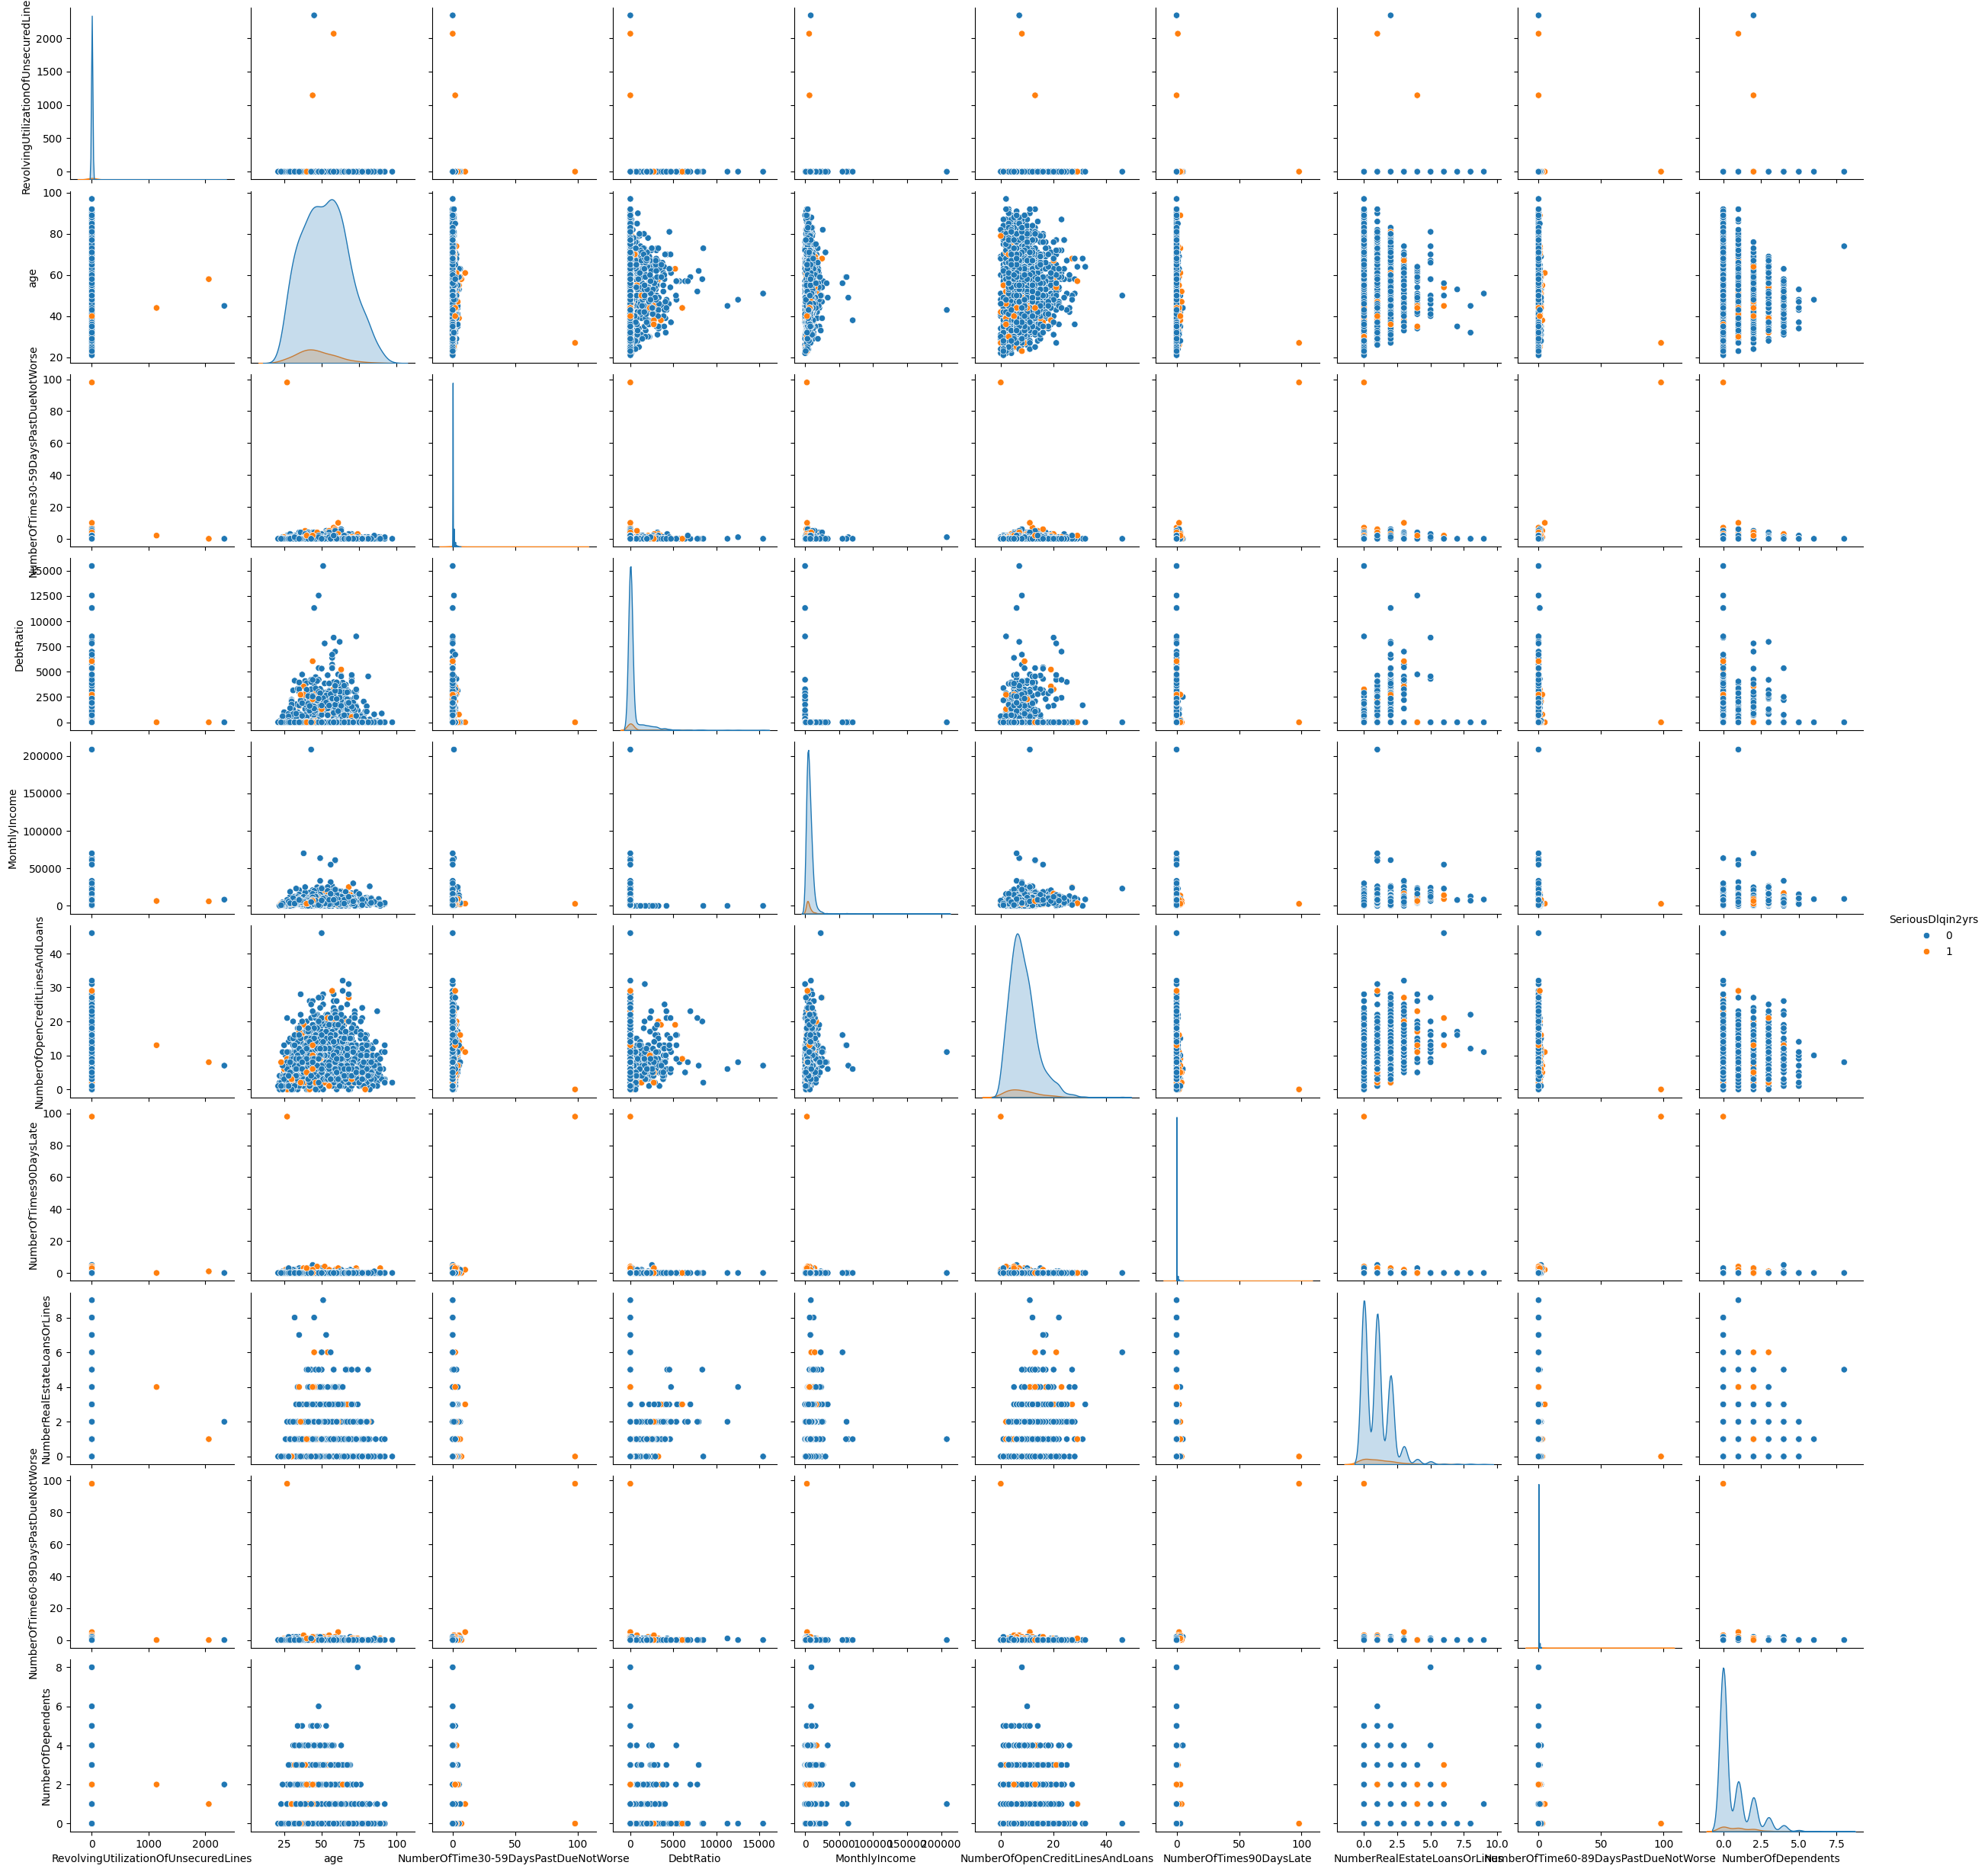

In [34]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

In [35]:
print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Описательный анализ данных 

### Удаление пропусков в наборе данных

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки, но пропуски будут заменены медианными значениями. 

In [36]:
nan_index_MonthlyIncome = data[data["MonthlyIncome"].isna() == True].index
nan_index_NumberOfDependents = data[data["NumberOfDependents"].isna() == True].index
median_MonthlyIncome = data["MonthlyIncome"].median()
median_NumberOfDependents = data["NumberOfDependents"].median()
data.loc[nan_index_MonthlyIncome, "MonthlyIncome"] = median_MonthlyIncome
data.loc[nan_index_NumberOfDependents, "NumberOfDependents"] = median_NumberOfDependents

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Поиск и удаление выбросов

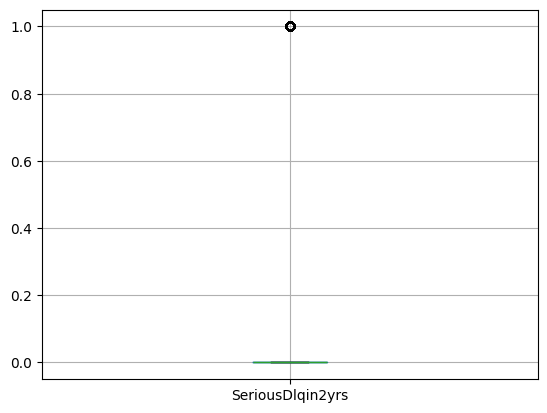

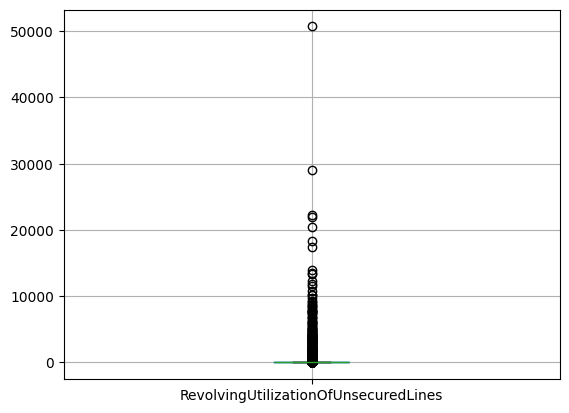

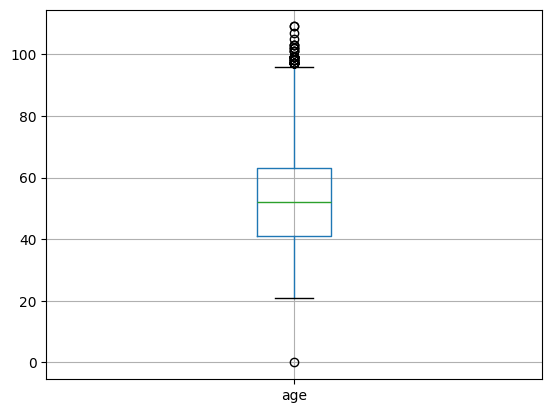

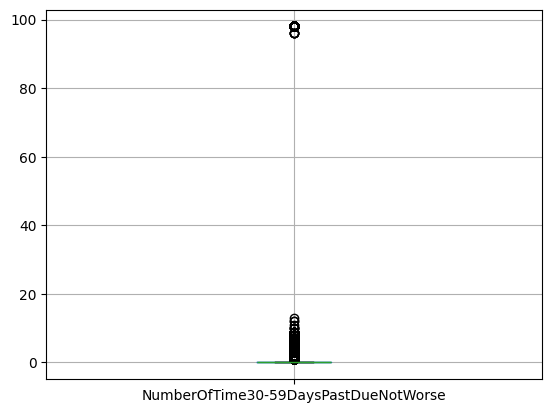

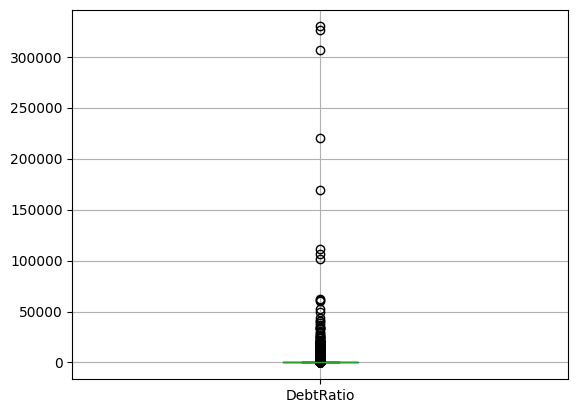

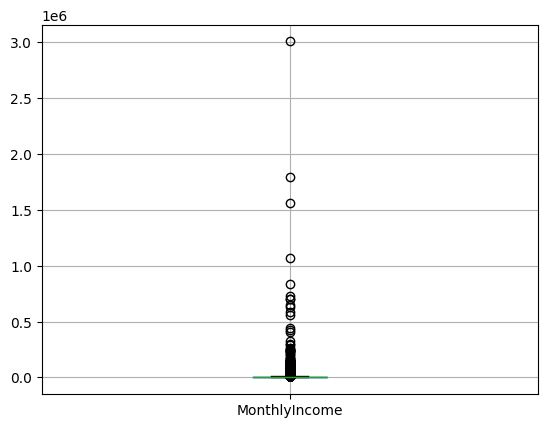

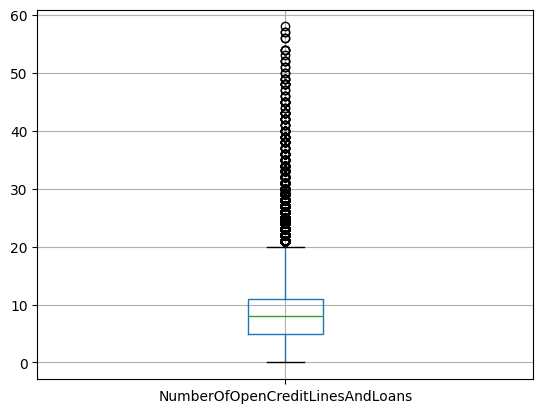

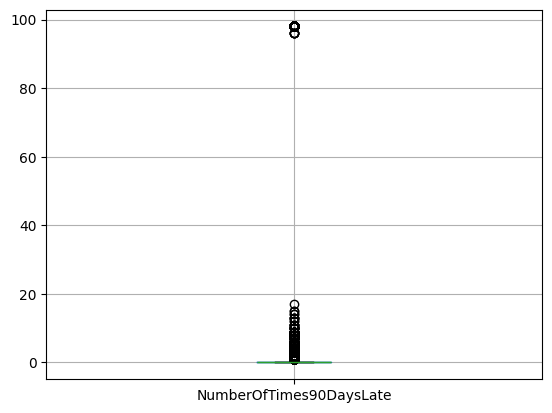

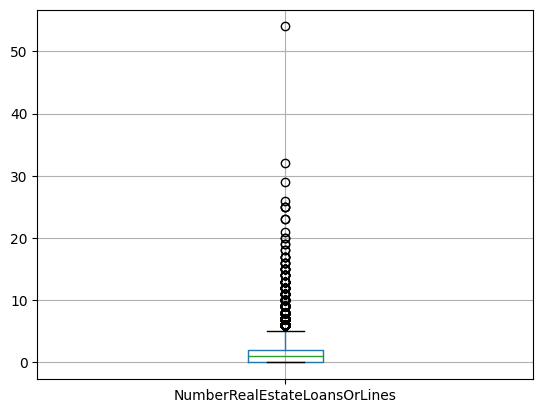

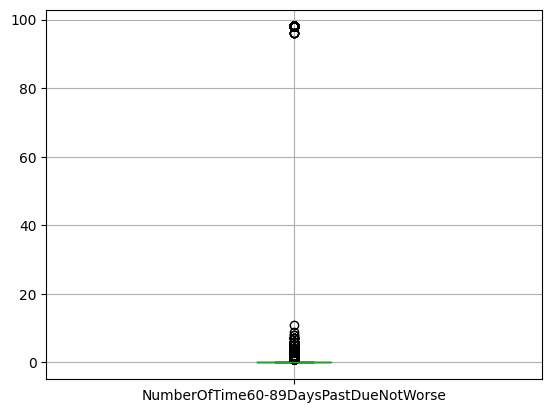

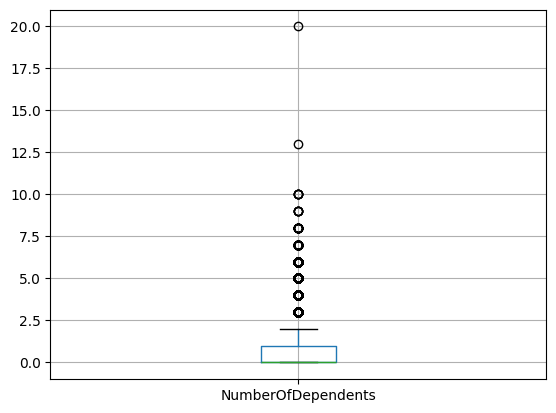

In [37]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 18 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 18 лет.

Другие, пока что, заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выбросы в этих признаках несут важную инфорацию. 

In [38]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 18
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [39]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].median()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

Теперь построим гистограмму распределения данных и обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

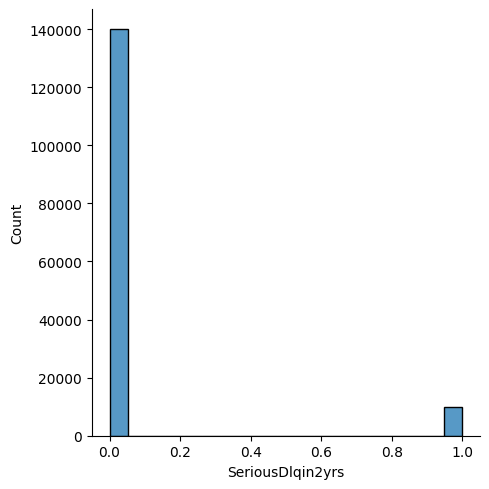

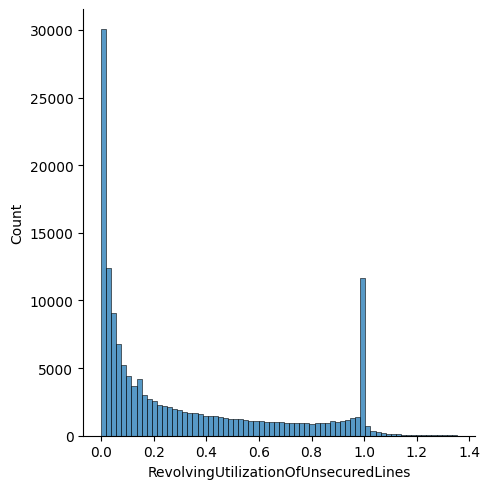

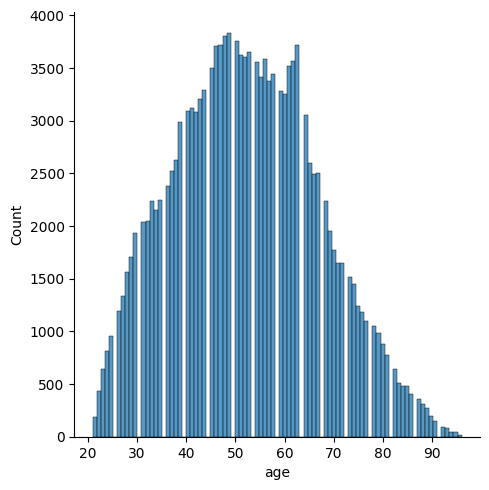

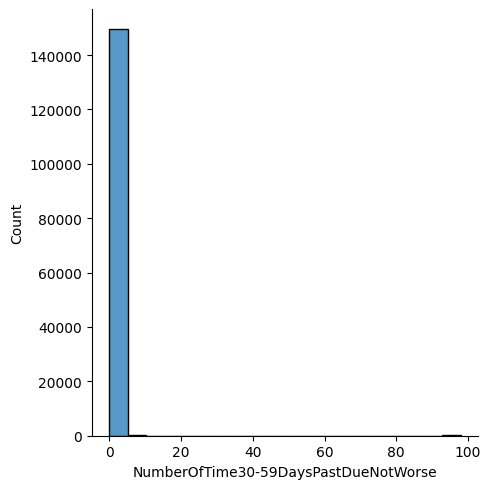

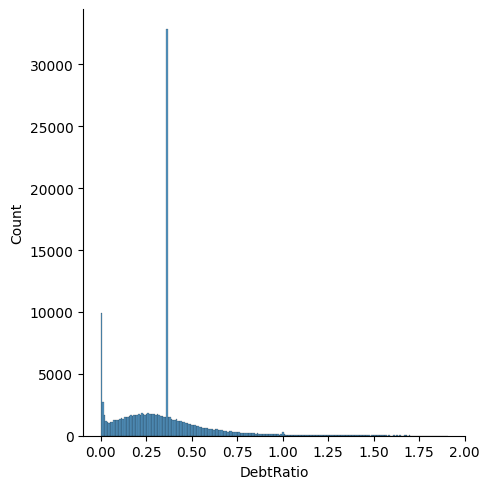

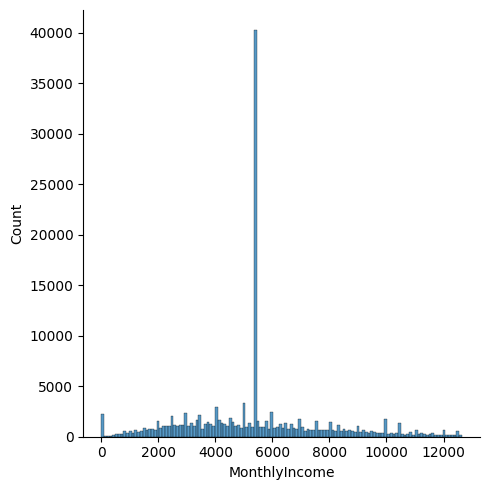

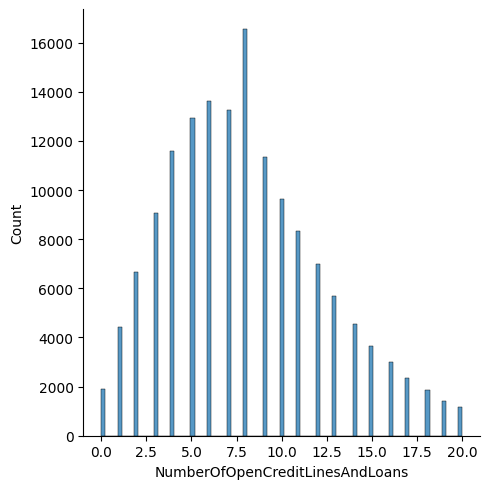

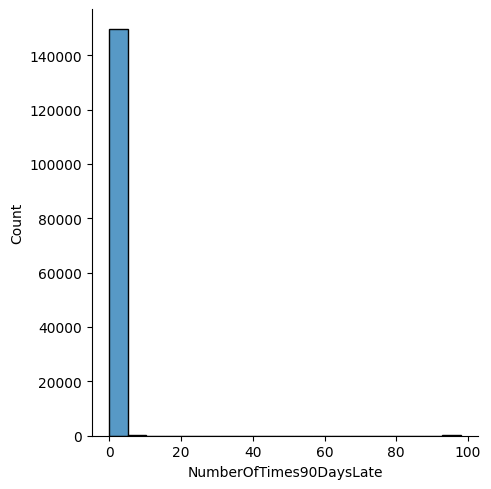

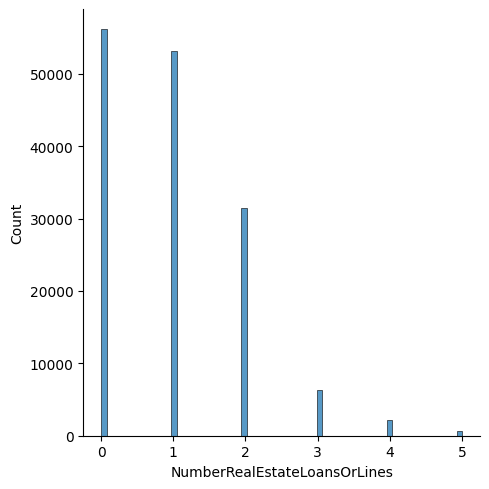

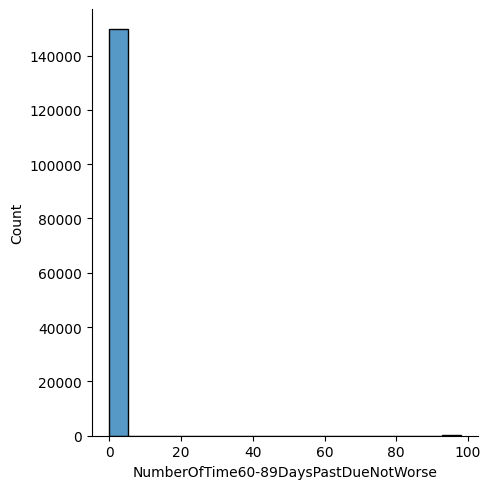

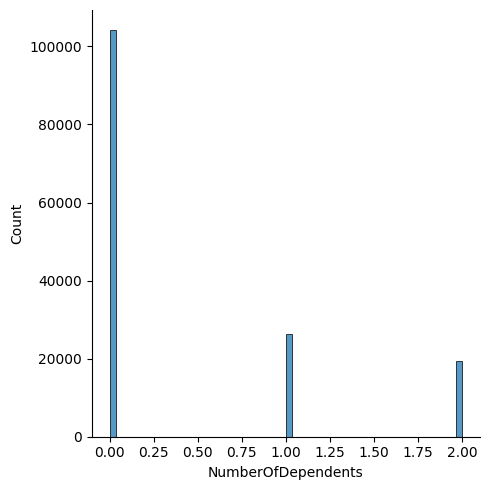

In [40]:
import seaborn as sns

for column in data.columns:
    display(sns.displot(data[column]))

## Построим корреляционную матрицу

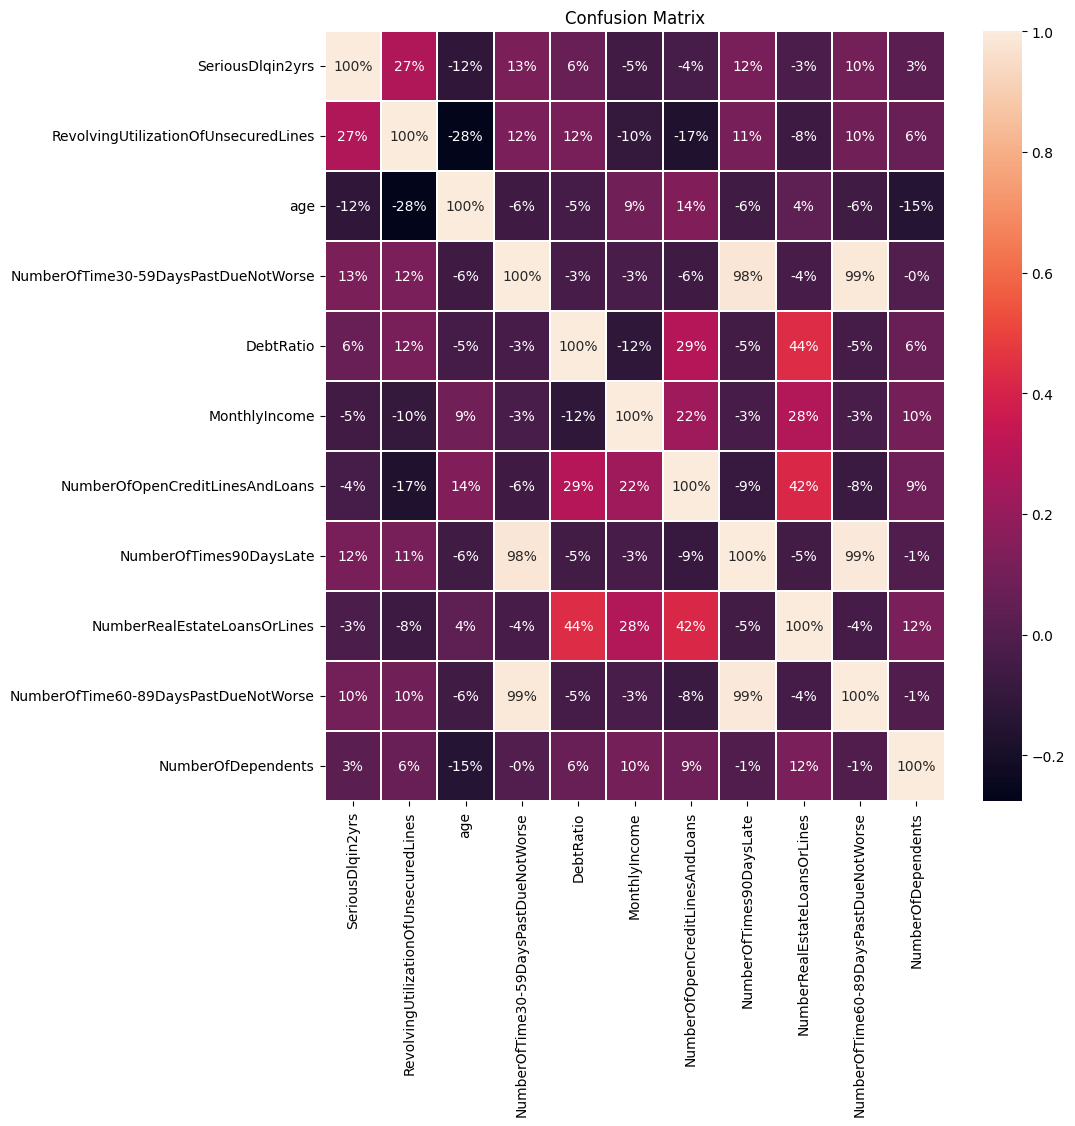

In [41]:
def draw_cov(data):
    figsize = (10,10)
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Confusion Matrix')
    se.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

draw_cov(data)

## Убираем признаки сильнокоррелирующие друг с другом

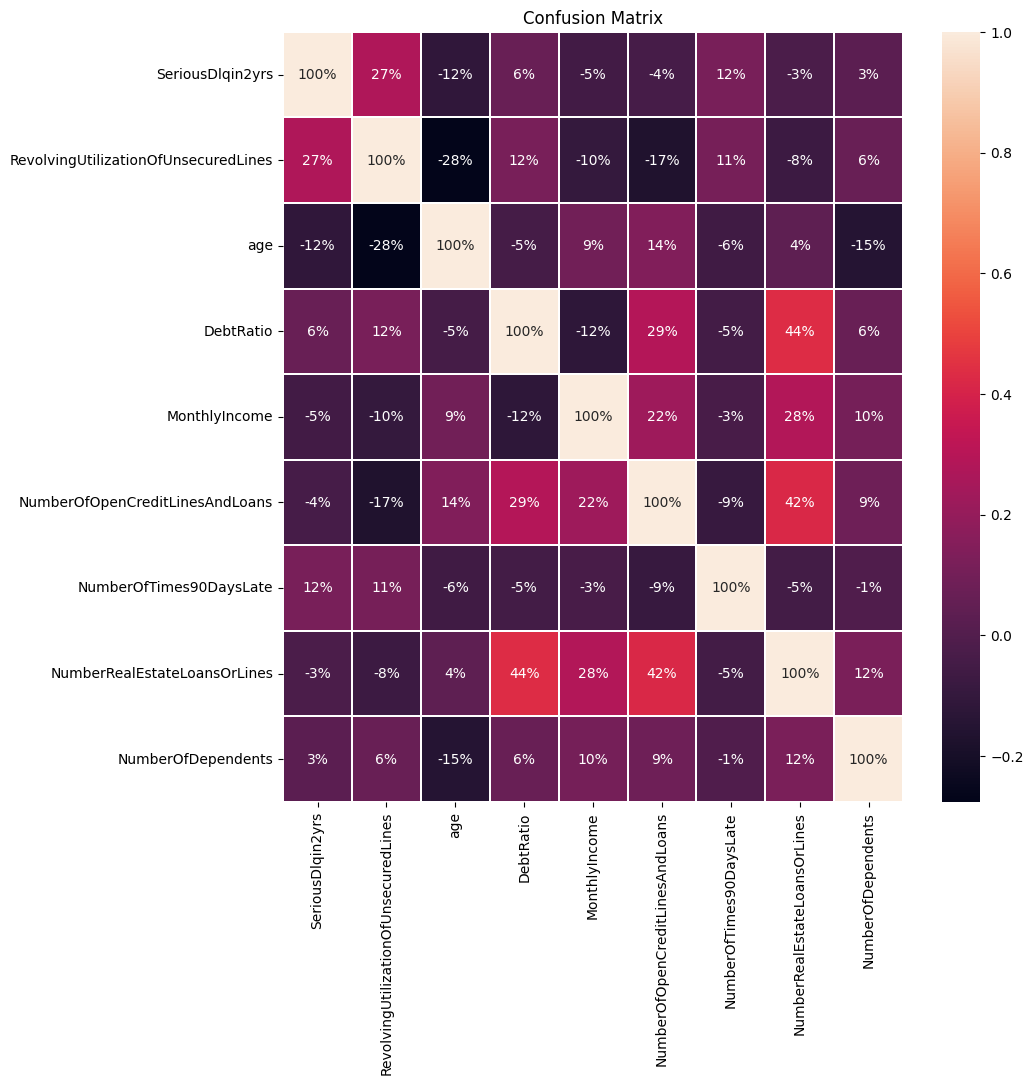

In [42]:
datacopy = copy.copy(data)
datacopy = datacopy.drop("NumberOfTime60-89DaysPastDueNotWorse", axis=1)
datacopy = datacopy.drop("NumberOfTime30-59DaysPastDueNotWorse", axis=1)
draw_cov(datacopy)

In [43]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,1,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,5400.0,7,0,1,0,0.0


In [94]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

## DecisionTreeClassifier

In [64]:
from sklearn.tree import DecisionTreeClassifier

pipline = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model_DT = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_DT.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y))}")

 Accuracy: 0.9005308223745632
 Cross validation score: 0.8972818483313139


## GaussianNB

In [65]:
from sklearn.naive_bayes import GaussianNB

pipline = make_pipeline(StandardScaler(), GaussianNB())
model_GNB = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_GNB.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y))}")

 Accuracy: 0.9338205873722959
 Cross validation score: 0.9329127619023729


## LogisticRegression

In [66]:
from sklearn.linear_model import LogisticRegression 

pipline = make_pipeline(StandardScaler(), LogisticRegression())
model_LogReg = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_LogReg.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y))}")

 Accuracy: 0.9351543119314999
 Cross validation score: 0.9342865149196864


## Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

pipline = make_pipeline(StandardScaler(), RandomForestClassifier())
model_RF = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_RF.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y))}")

 Accuracy: 0.9359812211582064
 Cross validation score: 0.9350134049884856


## Gradient Boosting

In [101]:
from sklearn.ensemble import GradientBoostingClassifier

pipline = make_pipeline(StandardScaler(), GradientBoostingClassifier(criterion="squared_error", max_depth=7, min_samples_leaf=9, min_samples_split=10, n_estimators=10))
model_GB = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_GB.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y))}")

 Accuracy: 0.9355544292992611
 Cross validation score: 0.9348200136377469


## KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier

pipline = make_pipeline(StandardScaler(), KNeighborsClassifier())
model_KNN = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_KNN.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y))}")

 Accuracy: 0.9325135373042759
 Cross validation score: 0.9324659551916925


## Neural Network

In [70]:
from sklearn.neural_network import MLPClassifier

pipline = make_pipeline(StandardScaler(), MLPClassifier())
model_MLP = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_MLP.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y))}")

 Accuracy: 0.9364346875083358
 Cross validation score: 0.9366339064773783


## AdaBoosting

In [97]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipline = make_pipeline(StandardScaler(), AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=9, min_samples_split=10), n_estimators=2))
model_Ada = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_Ada.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y))}")

 Accuracy: 0.9356344527728133
 Cross validation score: 0.9360937402038662


## Kaggle
Так как данные взяты с соревнования kaggle, то я пользуюсь возможностью проверки моделей на абсолютно новых для них данных и оценкой которой даёт система проверки kaggle:
1. **Decision Tree** - 0.498
2. **GaussianNB** - 0.313
3. **Logistic Regression** - 0.291
4. **Random Forest** - 0.194
5. **Gradient Boosting** - 0.154
6. **KNN** - 0.353
7. **Neural Network** - 0.234

Данные результаты получены на моделей "из коробки", то есть не проводилось никакой подгонки гиперпараметров. Как видно, в таком состоянии наиболее перспективной моделью является **Decision Tree**.

In [54]:
def try_kaggle(model, X):
    probs = model.predict_proba(X)
    ans = []
    for prob in probs:
        ans.append(np.max(prob))

    out_pd = pd.DataFrame({
        "Id": [i for i in range(1, len(ans) + 1)],
        "Probability": ans
    })
    out_pd.to_csv("out.csv", index=False)

In [102]:
data_test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)
X_test_test = data_test[data_test.columns[1:]].interpolate()
try_kaggle(model_GB, X_test_test)

## Подбор гиперпараметров, Байесовская оптимизация

In [81]:
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Определяем пространство поиска гиперпараметров
param_space = {
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'criterion': ['gini', 'entropy']
}

# Создаем объект BayesSearchCV для байесовской оптимизации
opt = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=param_space,
    n_iter=50,  # Количество итераций оптимизации
    cv=5,       # Количество фолдов для кросс-валидации
    n_jobs=-1,  # Использовать все доступные ядра CPU
    random_state=42
)

# Запускаем оптимизацию
opt.fit(X, y)

# Выводим лучшие параметры и соответствующую точность
print("Лучшие параметры:", opt.best_params_)
print("Лучшая точность:", opt.best_score_)

Лучшие параметры: OrderedDict({'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 10})
Лучшая точность: 0.9360670655347988
